#### <b>(알아보기) 필요한 라이브러리 불러오기</b>

* 실습을 위한 PyTorch 라이브러리를 불러옵니다.

### <b>실전 프로젝트 - CNN 기반 이미지 분류 모델의 강건성 평가</b>

* 다양한 딥러닝 분류 모델이 자율 주행 자동차, 얼굴 인식 등 <b>보안(security)</b>이 중요한 분야에서 활용되고 있습니다.
* 본 프로젝트에서는 공격자 입장에서 딥러닝 모델을 평가하는 <b>적대적 공격</b> 기법에 대하여 공부하게 됩니다.
    * 딥러닝 모델을 공격하는 다양한 적대적 공격(adversarial attack) 기법들을 구현할 수 있습니다.
    * 단계적으로 문제를 풀어보며 CNN 기반의 이미지 분류 모델의 <b>강건성(robustness)</b>을 평가하는 방법을 이해할 수 있습니다.
* GPU 가속기를 이용하기 위해 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 선택합니다.
* 본 프로젝트를 잘 수행하기 위해 다음의 YouTube 학습 자료를 참고하세요.
    * [MI-FGSM 논문 설명(YouTube)](https://www.youtube.com/watch?v=QCgujoTPbmU): FGSM, PGD, MI-FGSM 기법에 대하여 차례대로 설명하는 동영상입니다.
* 본 프로젝트에서는 다음의 두 가지 대표적인 공격 기법을 실습합니다.
    * 이미지를 눈에 띄지 않게 변경하여 <b>이미지 분류 모델의 오작동을 유도</b>합니다.
    1. [FGSM 공격 (ICLR 2015)](https://arxiv.org/abs/1412.6572)
    2. [PGD 공격 (ICLR 2018)](https://arxiv.org/abs/1706.06083)
* 본 프로젝트는 <b>총 5개의 문제</b>로 구성됩니다.
    * <b>Problem</b>이라고 명시된 부분의 소스코드만 작성합니다.
    * <b>알아보기</b>라고 명시된 부분은 단순히 읽고 실행하면 됩니다.
* <b>Problem 5</b>에서 최대한 높은 공격력(낮은 모델 정확도)을 내는 것이 여러분의 <b>최종 목표</b>입니다.
    * 자세한 평가 기준은 <b>Problem 5</b>에서 확인하세요.
* 최종적으로 <b>팀 단위로 제출할 파일</b>은 다음과 같습니다.
    1. Colab Notebook 파일: <b>[파일]</b> - <b>[다운로드]</b> - <b>[.ipynb 다운로드]</b>

#### <b>Problem 1. 데이터셋 다운로드</b>

* 실습을 위해 [<b>Small ImageNet Validation</b> 데이터셋](https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes)을 불러옵니다.
* 본 데이터셋은 5,000개의 ImageNet 평가 이미지로 구성됩니다.
    * 데이터셋은 총 1,000개의 클래스로 구성됩니다.
    * 각 클래스마다 5개의 이미지가 존재합니다.
* PyTorch에서 곧바로 불러와 사용할 수 있도록 구성된 데이터셋입니다.
* 다음의 명령어를 이용해 데이터셋을 다운로드할 수 있습니다.

<pre>
# 깃허브에서 데이터셋 다운로드하기
!git clone https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes
# 폴더 안으로 이동
%cd Small-ImageNet-Validation-Dataset-1000-Classes
</pre>


In [1]:
# 깃허브에서 데이터셋 다운로드하기
# !git clone https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes
# 폴더 안으로 이동
%cd Small-ImageNet-Validation-Dataset-1000-Classes

d:\다운로드\git\kdt_month4\Small-ImageNet-Validation-Dataset-1000-Classes


In [2]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import display

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>(알아보기) 데이터셋 불러오기</b>

* PyTorch의 <b>ImageFolder 라이브러리</b>를 이용하여 <b>자신만의 데이터셋</b>을 불러올 수 있습니다.
* ImageFolder 라이브러리는 다음과 같이 <b>계층적인 폴더 구조</b>에서 데이터셋을 불러올 때 사용할 수 있습니다.
    * 각 클래스명(class name)으로 된 폴더에 여러 장의 이미지가 들어가 있는 구조입니다.

<pre>
dataset/
    class 0/
        0.jpg
        1.jpg
        ...
    class 1/
        0.jpg
        1.jpg
        ...
    ...
    class 999/
        0.jpg
        1.jpg
        ...
</pre>

* 본 프로젝트에서는 평가 목적의 데이터셋만을 사용하므로, 데이터 증진(data augmentation)을 적용하지 않습니다.

In [3]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # 이미지 사이즈 변경
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
print('전체 이미지 개수:', len(val_dataset))

class_names = val_dataset.classes
print('클래스의 개수:', len(class_names))

# ImageNet 설정 파일에서 1,000개의 레이블을 불러오기
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

전체 이미지 개수: 5000
클래스의 개수: 1000


#### <b>(알아보기) 이미지 시각화하기</b>

* PyTorch로 불러온 데이터(torch.Tensor 객체)를 시각화해 봅시다.
* Google Colab에 출력하기 위해서 NumPy 형태로 변형한 뒤에 Matplotlib을 이용합니다.
    * torch.Tensor는 (Channel, Height, Width) 형식을 가집니다.
    * numpy 객체는 (Height, Width, Channel) 형식을 가집니다.

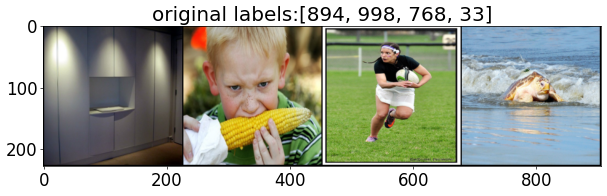

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: wardrobe, closet, press (894)
Image #2: ear, spike, capitulum (998)
Image #3: rugby ball (768)
Image #4: loggerhead, loggerhead turtle, Caretta caretta (33)


In [4]:
# 화면에 출력되는 이미지 크기를 적절하게 조절하기
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow_batch(image, title):
    # torch.Tensor => numpy 변환하기
    image = image.numpy().transpose((1, 2, 0))
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()


# 검증 데이터셋에서 하나의 배치를 불러와 보기
iterator = iter(val_dataloader)

# 현재 배치에 포함된 이미지를 출력하기
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

#### <b>(알아보기) 사전 학습된 모델 불러오기</b>

* 사전 학습된 PyTorch [ResNet-50](https://pytorch.org/vision/stable/models.html) 모델을 불러옵니다.
* 모델에 입력을 넣기 전에 자동으로 <b>정규화(normalization)</b>를 진행하도록 합니다.
    * 사전 학습된 CNN 모델(공격 대상)이 학습할 때 사용했던 설정(mean, std)을 그대로 이용합니다.

In [5]:
# 입력 데이터를 정규화(normalization)하는 클래스
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [6]:
resnet50 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.resnet50(pretrained=True)
).to(device).eval()

* 자신이 원하는 한 장의 이미지만 불러와 시각화하고 싶을 때는 다음과 같은 코드를 이용합니다.

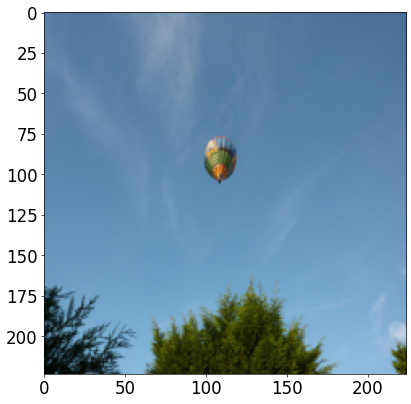

In [7]:
# 특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)


file_name = './ILSVRC2012_img_val_subset/417/ILSVRC2012_val_00002809.JPEG'
image = image_loader(file_name)
imshow(image)

* 한 장의 이미지를 특정한 모델에 넣어 결과를 얻고 싶다면 다음과 같은 코드를 이용합니다.
    * 가장 확률이 높은 5개의 클래스를 차례대로 출력합니다.

In [8]:
outputs = resnet50(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< 가장 확률이 높은 5개의 클래스 출력 >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")

< 가장 확률이 높은 5개의 클래스 출력 >
Index: 417 / Class name: balloon / Probability: 96.9239%
Index: 701 / Class name: parachute, chute / Probability: 2.9582%
Index: 805 / Class name: soccer ball / Probability: 0.0223%
Index: 768 / Class name: rugby ball / Probability: 0.0216%
Index: 405 / Class name: airship, dirigible / Probability: 0.0201%


#### <b>(알아보기) 사전 학습된 모델 평가하기</b>

* 사전 학습된 모델에 대하여 일반적인 정확도를 평가하는 함수를 작성합니다.
* 첫 번째 배치에 포함된 8개의 이미지를 분류 결과와 함께 화면에 출력합니다.

In [8]:
def validate(model):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for i, (inputs, basic_labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = torch.zeros_like(basic_labels).to(device)
            for j in range(labels.shape[0]):
                labels[j] = int(class_names[basic_labels[j]])
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            # if i == 0:
            #     print('[Prediction Result Examples]')
            #     images = torchvision.utils.make_grid(inputs[:4])
            #     imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
            #                 '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            #     print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            #     for j, imagenet_index in enumerate(labels[:4]):
            #         label = imagenet_labels[imagenet_index]
            #         print(f'Image #{j + 1}: {label} ({imagenet_index})')
            #     print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            #     for j, imagenet_index in enumerate(preds[:4]):
            #         label = imagenet_labels[imagenet_index]
            #         print(f'Image #{j + 1}: {label} ({imagenet_index})')
            #     images = torchvision.utils.make_grid(inputs[4:8])
            #     imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
            #                 '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            #     print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            #     for j, imagenet_index in enumerate(labels[4:8]):
            #         label = imagenet_labels[imagenet_index]
            #         print(f'Image #{j + 5}: {label} ({imagenet_index})')
            #     print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            #     for j, imagenet_index in enumerate(preds[4:8]):
            #         label = imagenet_labels[imagenet_index]
            #         print(f'Image #{j + 5}: {label} ({imagenet_index})')

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

In [14]:
validate(resnet50)

[Validation] Loss: 0.0620 Accuracy: 76.0800% Time elapsed: 10.7403s (total 5000 images)


#### <b>Problem 2. 다양한 모델들의 성능 비교하기</b>

* 다양한 사전 학습된 모델들에 대하여 평가를 진행합니다.
* PyTorch의 [Torchvision](https://pytorch.org/vision/stable/models.html)에서 제공하는 사전 학습된 모델들을 확인해 봅시다.
* 다음의 사전 학습된(Torchvision) 모델들에 대하여 평가를 진행하고 결과를 채워 넣으세요.
    * ResNet18: 67.86%
    * ResNet34: 72.26%
    * ResNet50: 76.08%
    * ResNet101: 76.74%
    * ResNet152: 77.42%
    * VGG16: 71.14%
    * VGG19: 71.16%
    * Inception v3: 68.00%
    * MobileNet v2: 70.96%
    * Alexnet: 52.86%
    * DenseNet 121: 72.90%
    * DenseNet 201: 75.22%

In [25]:
densenet201 = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.densenet201(pretrained=True)
).to(device).eval()

validate(densenet201)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\kairo/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:07<00:00, 10.1MB/s]


[Validation] Loss: 0.0632 Accuracy: 75.2200% Time elapsed: 13.8477s (total 5000 images)


#### <b>(알아보기) 공격 기법 평가 함수 작성하기</b>

* 일반적으로 적대적 공격(adversarial attack)은 ① 거리 ② 공격력이 평가 기준입니다.
* <b>거리</b>: Linf는 대표적인 거리 평가 기준으로, 가장 많이 변경된 픽셀(R, G, B 각각)의 변경된 정도를 의미합니다.
    * 일반적으로 각 픽셀이 16/255까지 변경되더라도 인간에게 크게 눈에 띄지 않는다고 가정합니다.
* <b>공격력</b>: 원본 클래스가 아니도록 만드는 공격(untargeted)에서는 <b>(100 - 모델의 정확도)</b>으로 공격력을 평가할 수 있습니다.
    * 본 프로젝트에서는 untargeted 공격만 가정합니다.

* 원본 이미지와의 거리 차이를 반환하는 함수를 정의합니다.
    * 본 프로젝트에서는 Linf 거리만을 사용합니다.
    * 참고로 일반적으로 PyTorch에서 모든 픽셀의 값은 [0, 1] 사이의 실수 값을 갖도록 합니다.

In [8]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

* 특정한 공격 기법을 이용해 특정한 모델의 <b>강건성(robustness)</b>을 평가하는 함수를 정의합니다.
    * <b>model</b>: 공격을 수행해 볼 모델
    * <b>attack</b>: 사용할 공격 기법

In [9]:
def attack_validate(model, attack):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    running_loss = 0.
    running_corrects = 0
    running_length = 0

    running_l0 = 0
    running_l2 = 0
    running_mse = 0
    running_linf = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).long().to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        adv_image, perturbation = attack.perturb(model, inputs, labels) # adversarial attack

        outputs = model(adv_image)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        running_length += labels.shape[0]

        l0, l2, mse, linf = get_distance(adv_image, inputs)
        running_l0 += l0.sum().item()
        running_l2 += l2.sum().item()
        running_mse += mse.sum().item()
        running_linf += linf.sum().item()

        if i == 0:
            print('The dimension of an image tensor:', inputs.shape[1:])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(adv_image[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(adv_image[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

        if i % 10 == 0:
            cur_running_loss = running_loss / running_length
            running_acc = running_corrects / running_length * 100.
            print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

    print('[Size of Perturbation]')
    print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
    print('Average L2 distance:', running_l2 / len(val_dataset))
    print('Average MSE:', running_mse / len(val_dataset))
    print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>(알아보기) FGSM 공격 클래스 정의하기</b>

* FGSM (Fast Gradient Sign Method)은 각 픽셀마다 비용이 증가하는 방향으로 eps만큼 변경하는 공격 기법입니다.
* FGSM은 딥러닝 분류 모델이 작은 크기의 perturbation에도 매우 취약할 수 있음을 보인 논문([ICLR 2015](https://arxiv.org/abs/1412.6572))입니다.

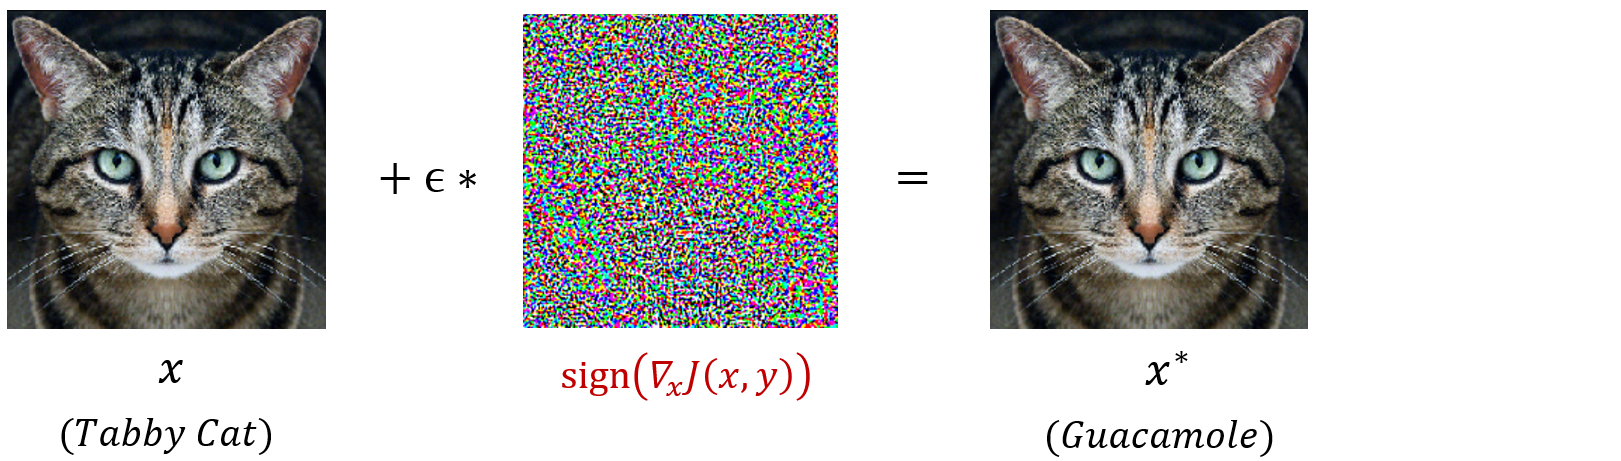

In [54]:
# FGSM 공격 클래스
class FGSM:
    def __init__(self, eps):
        self.eps = eps
    
    def perturb(self, model, images, labels):
        # 이미지와 레이블 데이터를 GPU로 옮기기
        images = images.to(device)
        labels = labels.to(device)

        # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
        perturbation = torch.zeros_like(images).to(device)
        # 손실(loss) 함수 설정
        attack_loss = nn.CrossEntropyLoss()

        # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
        perturbation.requires_grad = True

        outputs = model(images + perturbation) # 모델의 판단 결과 확인

        # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
        model.zero_grad()
        cost = attack_loss(outputs, labels).to(device)
        cost.backward()

        # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
        diff = perturbation.grad.sign()
        # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
        perturbation = torch.clamp(perturbation + diff, min=-self.eps, max=self.eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

        # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
        current = torch.clamp(images + perturbation, min=0, max=1)
        return current, perturbation

In [ ]:
# 풍선(balloon)이 아닌 클래스로 분류되도록 공격 수행
label = [417]
label = torch.Tensor(label)
label = label.type(torch.long)

# 공격 결과 계산하기
attack = FGSM(eps=16/255) # 공격용 파라미터 설정
adv_image, perturbation = attack.perturb(resnet50, image, label)

# 최종적으로 만들어진 공격 이미지 출력
plt.figure()
imshow(adv_image)

In [ ]:
# 완성된 공격 이미지를 실제 모델에 넣어 결과 확인
outputs = resnet50(adv_image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

In [ ]:
attack = FGSM(eps=16/255) # 공격용 파라미터 설정
attack_validate(resnet50, attack)

#### <b>Problem 3. FGSM 공격 성능 분석하기</b>

* <b>적대적 노이즈(adversarial noise)</b>의 크기를 조절하며 FGSM 공격 결과를 분석합니다.
    * 적대적 노이즈를 perturbation라고도 부릅니다.
    * perturbation의 크기(원본 이미지와의 거리) 값인 eps이 커질수록 인간의 눈에 잘 띄게 됩니다.
    * 일반적으로 Linf 기준으로 eps 값을 16/255로 설정하여 각 픽셀이 16/255만큼 바뀔 수 있도록 합니다.
* 다음의 <b>eps 값을 바꾸어 가며</b> ResNet50 모델을 공격한 뒤에 모델의 정확도를 확인하세요.
    * FGSM 공격 (eps=1/255): 11.00%
    * FGSM 공격 (eps=2/255): 6.30%
    * FGSM 공격 (eps=4/255): 5.48%
    * FGSM 공격 (eps=8/255): 6.80%
    * FGSM 공격 (eps=16/255): 8.98%
    * FGSM 공격 (eps=32/255): 7.42%
    * FGSM 공격 (eps=64/255): 0.70%
* 본 실습에서는 모델의 정확도가 낮을수록, 공격력이 높은 것입니다.

In [ ]:
attack = FGSM(eps=128/255) # 공격용 파라미터 설정
attack_validate(resnet50, attack)

#### <b>(알아보기) PGD 공격 클래스 정의하기</b>

* PGD (Fast Gradient Sign Method) 공격(Linf)은 FGSM을 반복적으로 수행하는 것과 유사합니다.
    * 한꺼번에 각 픽셀을 eps만큼 바꾸지 않습니다.
    * <b>여러 번의 스텝(step)</b>으로 나누어 각 픽셀을 alpha만큼 조금씩 바꿉니다.
* PGD 공격은 적은 스텝(step = iters)만으로도 충분히 강력한 perturbation을 만들 수 있다는 장점이 있습니다.
    * 필요시 원본 논문([ICLR 2018](https://arxiv.org/abs/1706.06083))을 참고합니다.

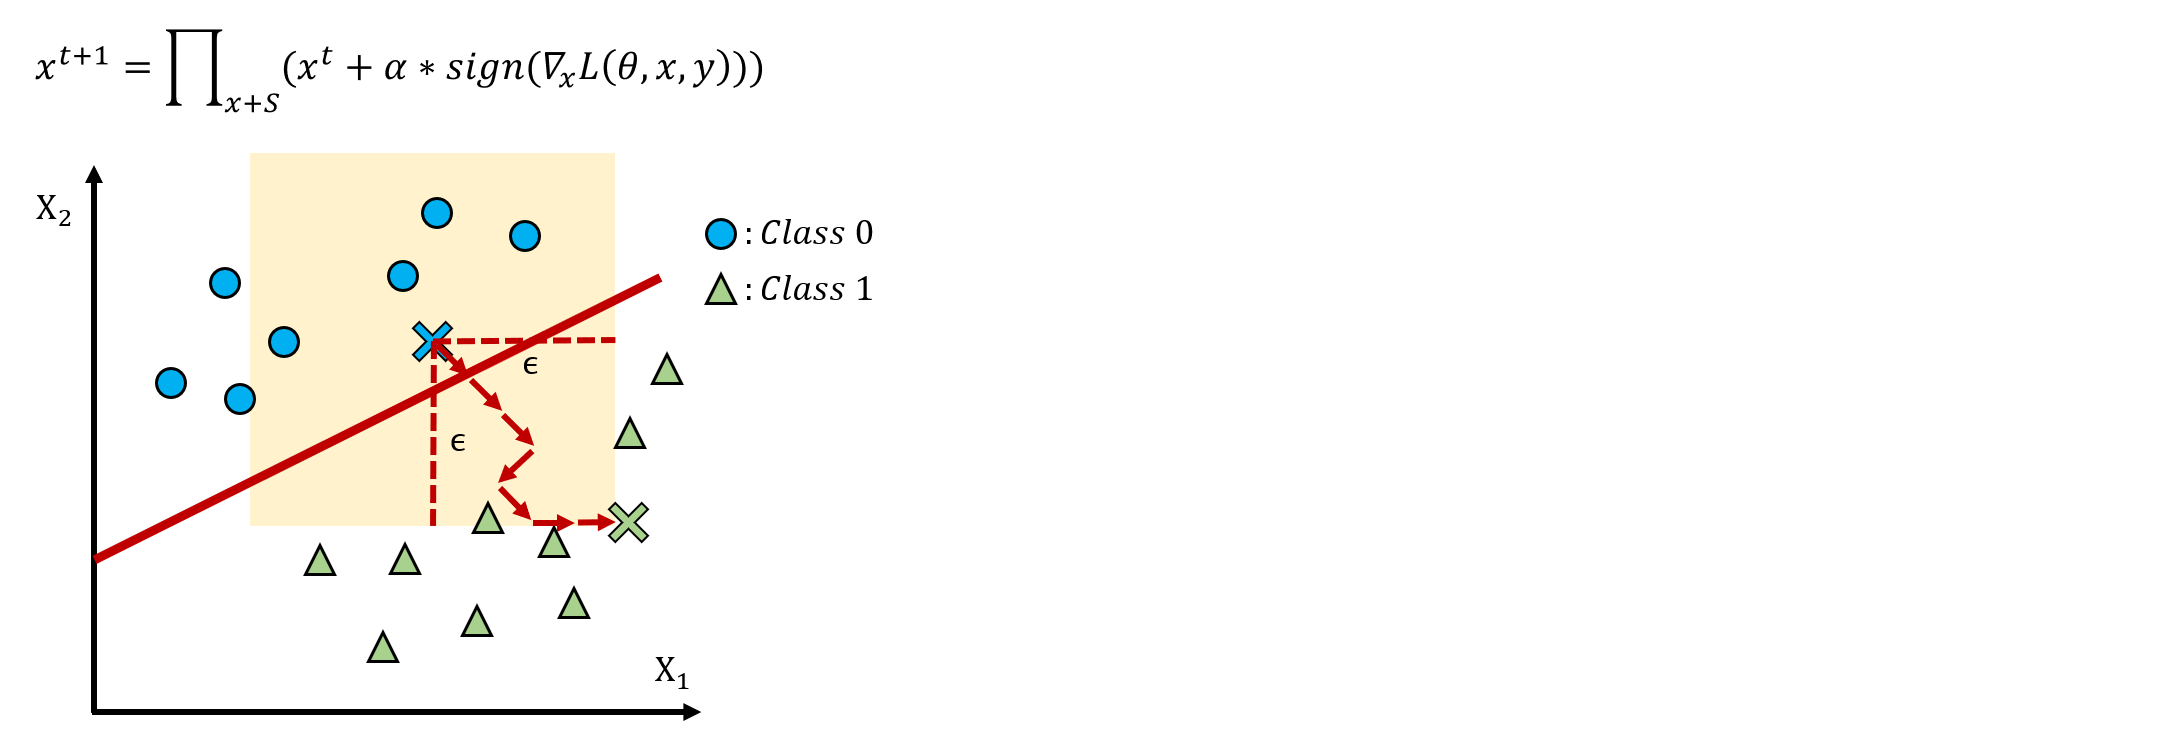

In [40]:
# PGD 공격 클래스
class PGD:
    def __init__(self, eps, alpha, iters):
        self.eps = eps
        self.alpha = alpha
        self.iters = iters # 반복 횟수(step size)
    
    def perturb(self, model, images, labels):
        # 이미지와 레이블 데이터를 GPU로 옮기기
        images = images.to(device)
        labels = labels.to(device)

        # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
        # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
        perturbation = torch.empty_like(images).uniform_(-self.eps, self.eps)
        perturbation.to(device)
        # 손실(loss) 함수 설정
        attack_loss = nn.CrossEntropyLoss()

        for i in range(self.iters):
            # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
            perturbation.requires_grad = True

            # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
            current = torch.clamp(images + perturbation, min=0, max=1)
            outputs = model(current) # 모델의 판단 결과 확인

            # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
            model.zero_grad()
            cost = attack_loss(outputs, labels).to(device)
            cost.backward()

            # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
            diff = self.alpha * perturbation.grad.sign()
            # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
            perturbation = torch.clamp(perturbation + diff, min=-self.eps, max=self.eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

        # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
        current = torch.clamp(images + perturbation, min=0, max=1)
        return current, perturbation

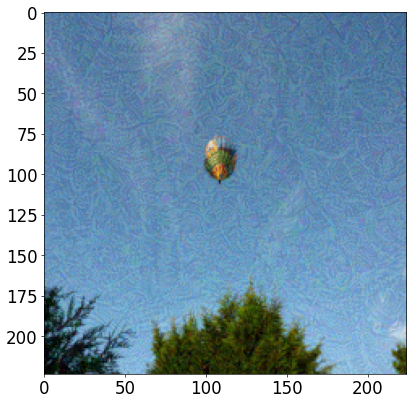

In [41]:
# 풍선(balloon)이 아닌 클래스로 분류되도록 공격 수행
label = [417]
label = torch.Tensor(label)
label = label.type(torch.long)

# 공격 결과 반환
attack = PGD(eps=16/255, alpha=4/255, iters=7) # 공격용 파라미터 설정
adv_image, perturbation = attack.perturb(resnet50, image, label)

# 최종적으로 만들어진 공격 이미지 출력
plt.figure()
imshow(adv_image)

In [42]:
# 완성된 공격 이미지를 실제 모델에 넣어 결과 확인
outputs = resnet50(adv_image)
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {imagenet_labels[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >
인덱스: 815 / 클래스명: spider web, spider's web / 확률: 99.5348%
인덱스: 73 / 클래스명: barn spider, Araneus cavaticus / 확률: 0.4159%
인덱스: 74 / 클래스명: garden spider, Aranea diademata / 확률: 0.0487%
인덱스: 72 / 클래스명: black and gold garden spider, Argiope aurantia / 확률: 0.0006%
인덱스: 77 / 클래스명: wolf spider, hunting spider / 확률: 0.0001%


The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


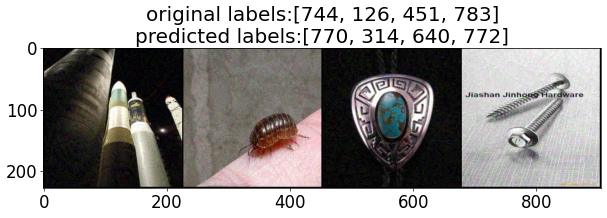

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: projectile, missile (744)
Image #2: isopod (126)
Image #3: bolo tie, bolo, bola tie, bola (451)
Image #4: screw (783)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: running shoe (770)
Image #2: cockroach, roach (314)
Image #3: manhole cover (640)
Image #4: safety pin (772)


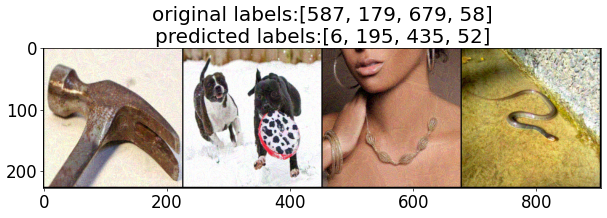

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: hammer (587)
Image #6: Staffordshire bullterrier, Staffordshire bull terrier (179)
Image #7: necklace (679)
Image #8: water snake (58)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: stingray (6)
Image #6: Boston bull, Boston terrier (195)
Image #7: bathtub, bathing tub, bath, tub (435)
Image #8: thunder snake, worm snake, Carphophis amoenus (52)
[Step #0] Loss: 2.8331 Accuracy: 0.0000% Time elapsed: 2.0984s (total 16 images)
[Step #10] Loss: 2.8030 Accuracy: 0.0000% Time elapsed: 5.5993s (total 176 images)
[Step #20] Loss: 2.8446 Accuracy: 0.0000% Time elapsed: 8.8618s (total 336 images)
[Step #30] Loss: 2.8331 Accuracy: 0.0000% Time elapsed: 12.2092s (total 496 images)
[Step #40] Loss: 2.8277 Accuracy: 0.0000% Time elapsed: 15.9072s (total 656 images)
[Step #50] Loss: 2.8218 Accuracy: 0.0000% Time elapsed: 19.2210s (total 816 images)
[Step #60] Loss: 2.8329 Accuracy: 0.0000% Time elapsed: 22.6049s (total 976 images)
[Step #70] 

In [43]:
attack = PGD(eps=16/255, alpha=4/255, iters=7) # 공격용 파라미터 설정
attack_validate(resnet50, attack)

#### <b>Problem 4. PGD 공격 성능 분석하기</b>

* <b>적대적 노이즈(adversarial noise)</b>의 크기를 조절하며 PGD 공격 결과를 분석합니다.
    * 일반적으로 alpha 값은 eps / 4, step size는 7을 이용합니다. (기본 설정)
* 다음의 <b>eps 값을 바꾸어 가며</b> ResNet50 모델을 공격한 뒤에 모델의 정확도를 확인하세요.
    * 본 코드에서는 alpha와 step 파라미터는 기본 설정을 유지합니다.
    * PGD 공격 (eps=1/255): 4.82%
    * PGD 공격 (eps=2/255): 1.36%
    * PGD 공격 (eps=4/255): 0.02%
    * PGD 공격 (eps=8/255): 0.00%
    * PGD 공격 (eps=16/255): 0.00%
    * PGD 공격 (eps=32/255): 0.00%
    * PGD 공격 (eps=64/255): 0.00%
* 본 실습에서는 모델의 정확도가 낮을수록, 공격력이 높은 것입니다.

In [ ]:
attack = PGD(eps=64/255, alpha=4/255, iters=7) # 공격용 파라미터 설정
attack_validate(resnet50, attack)

#### <b>(알아보기) Black-box 공격 개요</b>

* 지금까지의 실습에서는 공격자가 사전 학습된 공격 대상 모델의 모든 정보를 알고 있었습니다.
    * 학습된 가중치(weight)를 알고 있을 때는 역전파(backpropagation)가 가능합니다.
    * 하지만 <b>공격 대상 모델의 가중치를 모를 때</b>는 어떻게 공격할 수 있을까요?
* 적대적 예제(adversarial example)은 모델 사이에서 전송 가능한(transferable) 특징이 있습니다.
* 이러한 <b>transferability를 이용한 공격 방법</b>은 다음과 같습니다.
    1. 공격자가 개인적으로 공격 대상 모델(black-box)과 유사한 대체 모델(substitute model)을 학습합니다.
    2. 자신의 대체 모델에 대하여 white-box 공격을 수행해 adversarial example을 생성합니다.
    3. 해당 adversarial example을 공격 대상인 black-box 모델에 넣어 최종적으로 공격을 수행합니다.

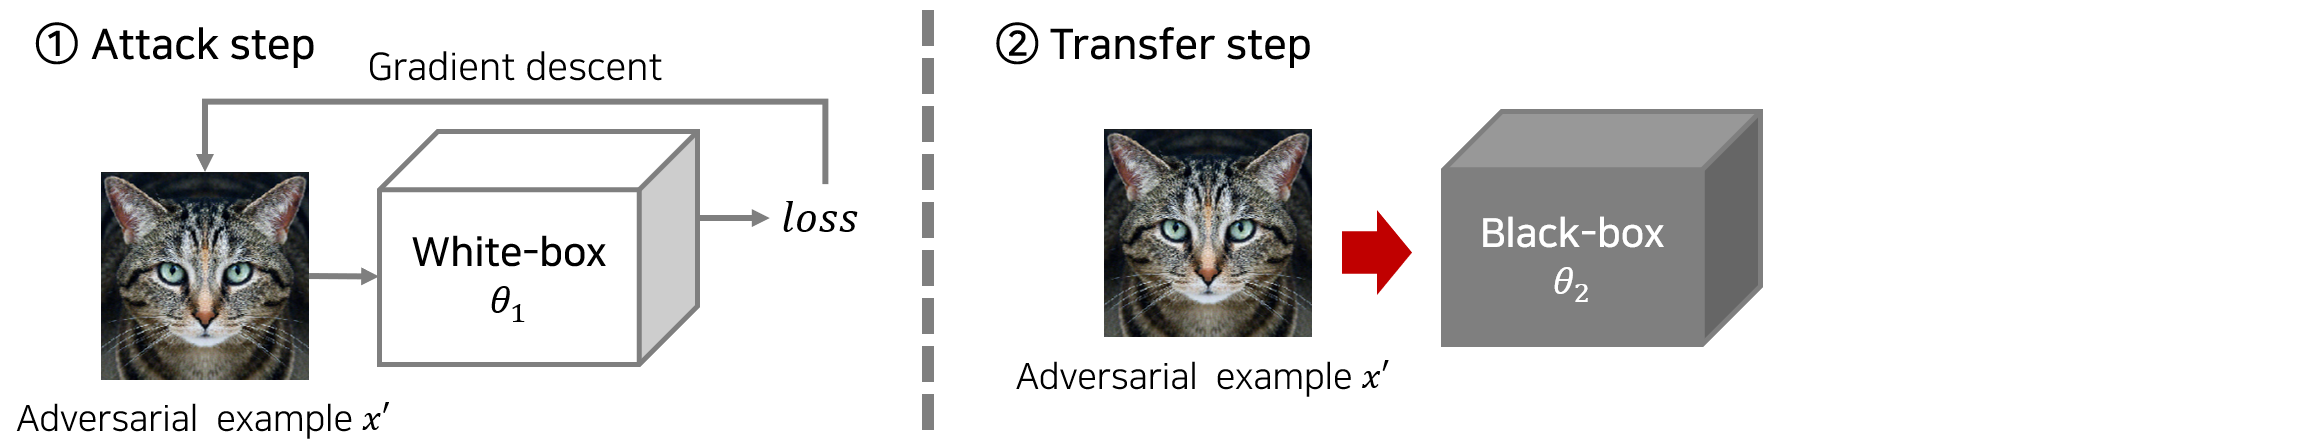

#### <b>Problem 5. 강력한 Black-box 공격 기법 설계하기</b>

* 나만의 공격 알고리즘을 이용하여 black-box 상황에서 Inception v3 모델을 공격해 보세요.
* (Hint) MI-FGSM ([CVPR 2018](https://arxiv.org/abs/1710.06081))을 사용해 보세요.
    * [YouTube 설명 링크](https://www.youtube.com/watch?v=QCgujoTPbmU)
* (Hint) 내가 갖고 있는 모델의 앙상블에 대하여 생성한 perturbation을 활용할 수 있습니다.
* (중요) 공격 대상이 되는 <b>Inception v3에 대해서는 forward()만 가능</b>하다고 가정합니다.
    * Inception v3 모델을 대상으로 역전파(backpropagation)를 수행하면 안 됩니다.
    * Inception v3를 제외한 다른 모델은 몇 개라도 사용해도 괜찮지만, <b>Inception 계열의 모델은 사용할 수 없습니다.</b>
    * Inception 계열의 모델: Inception v3, Inception v4, Inception-ResNet-V2 등 이름에 <b>Inception</b>이 들어간 모델
* (중요) 모든 이미지에 대하여 각 픽셀을 최대 16/255만큼 바꿀 수 있습니다.
    * 다시 말해 모든 이미지에 대하여 Linf 거리가 0.062745 (16/255)이하여야 합니다.
    * eps은 16/255으로 고정하되, alpha나 step을 자유롭게 바꾸어 보는 방법을 추천합니다.
* 아래 코드에서 black_box_attack_validate() 함수와, CustomAttack 클래스는 변경이 가능합니다.
    * 하지만 black_box_model에 대하여 forward()만 수행해야 한다는 점에 꼭 유의하세요. (역전파 불가)
* 점수 판정 기준
    * <b>black-box 모델의 정확도(accuracy)가 가장 낮게 나오는 팀</b>이 1등입니다.
* 최종적으로 <b>팀 단위로 제출할 파일</b>은 다음과 같습니다.
    1. Colab Notebook 파일: <b>[파일]</b> - <b>[다운로드]</b> - <b>[.ipynb 다운로드]</b>

In [10]:
# 이 코드는 바꾸실 수 없습니다.
black_box_model = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.inception_v3(pretrained=True)
).to(device).eval()

In [11]:
def black_box_attack_validate(model, black_box_model, attack):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    running_loss = 0.
    running_corrects = 0
    running_length = 0

    running_l0 = 0
    running_l2 = 0
    running_mse = 0
    running_linf = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).long().to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        # adv_image, perturbation = attack.perturb(model, inputs, labels) # adversarial attack
        adv_image = attack.perturb(model, inputs, labels) # adversarial attack

        outputs = black_box_model(adv_image)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        running_length += labels.shape[0]

        l0, l2, mse, linf = get_distance(adv_image, inputs)
        running_l0 += l0.sum().item()
        running_l2 += l2.sum().item()
        running_mse += mse.sum().item()
        running_linf += linf.sum().item()

        if i == 0:
            print('The dimension of an image tensor:', inputs.shape[1:])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(adv_image[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(adv_image[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

        if i % 10 == 0:
            cur_running_loss = running_loss / running_length
            running_acc = running_corrects / running_length * 100.
            print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

    print('[Size of Perturbation]')
    print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
    print('Average L2 distance:', running_l2 / len(val_dataset))
    print('Average MSE:', running_mse / len(val_dataset))
    print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

* 아래는 커스텀 공격 클래스 예시 코드입니다.

In [33]:
# 커스텀 공격 클래스 예시
class CustomAttack:
    def __init__(self, eps, alpha, iters):
        self.eps = eps
        self.alpha = alpha
        self.iters = iters
    
    def perturb(self, model, images, labels):
        # 이미지와 레이블 데이터를 GPU로 옮기기
        images = images.to(device)
        labels = labels.to(device)

        # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
        # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
        perturbation = torch.empty_like(images).uniform_(-self.eps, self.eps)
        perturbation.to(device)
        # 손실(loss) 함수 설정
        attack_loss = nn.CrossEntropyLoss()

        for i in range(self.iters):
            # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
            perturbation.requires_grad = True

            # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
            current = torch.clamp(images + perturbation, min=0, max=1)
            outputs = model(current) # 모델의 판단 결과 확인

            # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
            model.zero_grad()
            cost = attack_loss(outputs, labels).to(device)
            cost.backward()

            # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
            diff = self.alpha * perturbation.grad.sign()
            # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
            perturbation = torch.clamp(perturbation + diff, min=-self.eps, max=self.eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

        # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
        current = torch.clamp(images + perturbation, min=0, max=1)
        return current, perturbation

In [31]:
class MI_FGSM:
    def __init__(self, eps, iters, decay):
        self.eps = eps
        self.alpha = eps / iters
        self.iters = iters
        self.decay = decay
    
    def perturb(self, model, images, labels):
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad = True
        size = images.shape[0]

        g = torch.zeros_like(images)
        g = g.to(device)

        attack_loss = nn.CrossEntropyLoss()

        for i in range(self.iters):
            outputs = model(images)
            
            model.zero_grad()
            images.retain_grad()
            cost = attack_loss(outputs, labels).to(device)
            cost.backward(retain_graph=True)
            
            images_grad_norm = images.grad.reshape(size, -1).norm(p=1, dim=1).reshape(size, 1, 1, 1)
            g = self.decay*g + images.grad / images_grad_norm
            images = torch.clamp(images + self.alpha*g.sign(), min=0, max=1)

        return images

* 아래 코드는 블랙박스 공격 예제 코드입니다.
    * 블랙박스 모델(Inception v3)에 대하여 정확도를 44.02%까지 떨어뜨렸습니다.
    * 여러분은 얼마나 더 떨어뜨릴 수 있으신가요?

In [12]:
resnet152 = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.resnet152(pretrained=True)
).to(device).eval()

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


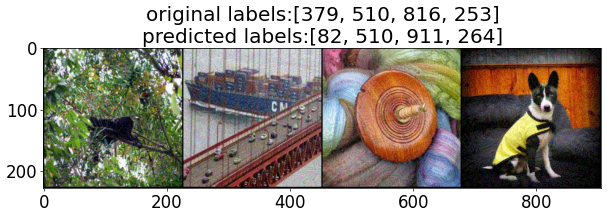

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: howler monkey, howler (379)
Image #2: container ship, containership, container vessel (510)
Image #3: spindle (816)
Image #4: basenji (253)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ruffed grouse, partridge, Bonasa umbellus (82)
Image #2: container ship, containership, container vessel (510)
Image #3: wool, woolen, woollen (911)
Image #4: Cardigan, Cardigan Welsh corgi (264)


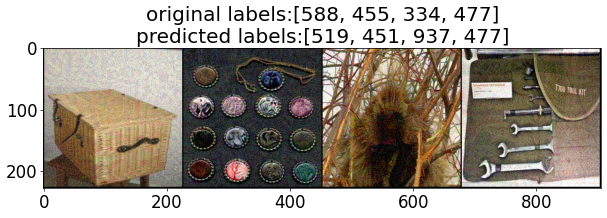

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: hamper (588)
Image #6: bottlecap (455)
Image #7: porcupine, hedgehog (334)
Image #8: carpenter's kit, tool kit (477)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: crate (519)
Image #6: bolo tie, bolo, bola tie, bola (451)
Image #7: broccoli (937)
Image #8: carpenter's kit, tool kit (477)
[Step #0] Loss: 0.3192 Accuracy: 25.0000% Time elapsed: 2.9957s (total 16 images)
[Step #10] Loss: 0.3879 Accuracy: 26.1364% Time elapsed: 7.7362s (total 176 images)
[Step #20] Loss: 0.4079 Accuracy: 25.0000% Time elapsed: 12.8623s (total 336 images)
[Step #30] Loss: 0.4101 Accuracy: 24.7984% Time elapsed: 17.8610s (total 496 images)
[Step #40] Loss: 0.4104 Accuracy: 24.0854% Time elapsed: 22.6573s (total 656 images)
[Step #50] Loss: 0.4062 Accuracy: 25.6127% Time elapsed: 27.2114s (total 816 images)
[Step #60] Loss: 0.4092 Accuracy: 25.5123% Time elapsed: 32.0804s (total 976 images)
[Step #70] Loss: 0.3999 Accuracy: 26.3204% Time elapsed: 37.0

In [36]:
# 블랙박스 공격 예제 코드입니다.
custom_attack = MI_FGSM(eps=16/255, iters=4, decay=1.2) # 공격용 파라미터 설정
black_box_attack_validate(resnet152, black_box_model, custom_attack)

In [37]:
torch.cuda.empty_cache()

In [19]:
def black_box_attack_validate_ensemble(models, weights, black_box_model, attack):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    running_loss = 0.
    running_corrects = 0
    running_length = 0

    running_l0 = 0
    running_l2 = 0
    running_mse = 0
    running_linf = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).long().to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        # adv_image, perturbation = attack.perturb(model, inputs, labels) # adversarial attack
        adv_image = attack.perturb(models, weights, inputs, labels) # adversarial attack

        outputs = black_box_model(adv_image)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        running_length += labels.shape[0]

        l0, l2, mse, linf = get_distance(adv_image, inputs)
        running_l0 += l0.sum().item()
        running_l2 += l2.sum().item()
        running_mse += mse.sum().item()
        running_linf += linf.sum().item()

        if i == 0:
            print('The dimension of an image tensor:', inputs.shape[1:])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(adv_image[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(adv_image[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

        if i % 10 == 0:
            cur_running_loss = running_loss / running_length
            running_acc = running_corrects / running_length * 100.
            print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

    print('[Size of Perturbation]')
    print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
    print('Average L2 distance:', running_l2 / len(val_dataset))
    print('Average MSE:', running_mse / len(val_dataset))
    print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

In [39]:
class MI_FGSM_ENSEMBLE:
    def __init__(self, eps, iters, decay):
        self.eps = eps
        self.alpha = eps / iters
        self.iters = iters
        self.decay = decay
    
    def perturb(self, models, weights, images, labels):
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad = True
        size = images.shape[0]

        g = torch.zeros_like(images)
        g = g.to(device)

        attack_loss = nn.CrossEntropyLoss()

        for i in range(self.iters):
            outputs = 0
            
            for model, weight in zip(models, weights):
                output = model(images)
                
                model.zero_grad()
                outputs += weight*output
            
            images.retain_grad()
            cost = attack_loss(outputs, labels).to(device)
            cost.backward(retain_graph=True)
            
            images_grad_norm = images.grad.reshape(size, -1).norm(p=1, dim=1).reshape(size, 1, 1, 1)
            g = self.decay*g + images.grad / images_grad_norm
            images = torch.clamp(images + self.alpha*g.sign(), min=0, max=1)

        return images

In [13]:
vgg19 = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.vgg19(pretrained=True)
).to(device).eval()

In [14]:
mobilenet_v2 = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.mobilenet_v2(pretrained=True)
).to(device).eval()

In [15]:
densenet201 = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.densenet201(pretrained=True)
).to(device).eval()

In [16]:
alexnet = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.alexnet(pretrained=True)
).to(device).eval()

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


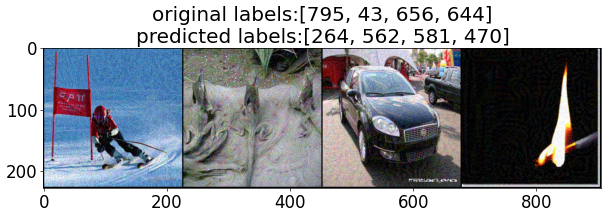

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ski (795)
Image #2: frilled lizard, Chlamydosaurus kingi (43)
Image #3: minivan (656)
Image #4: matchstick (644)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Cardigan, Cardigan Welsh corgi (264)
Image #2: fountain (562)
Image #3: grille, radiator grille (581)
Image #4: candle, taper, wax light (470)


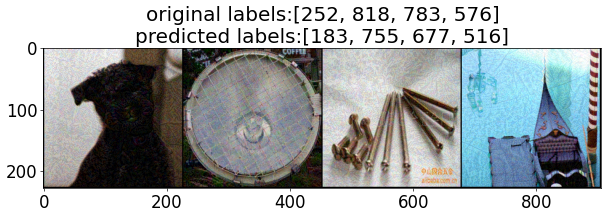

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: affenpinscher, monkey pinscher, monkey dog (252)
Image #6: spotlight, spot (818)
Image #7: screw (783)
Image #8: gondola (576)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Kerry blue terrier (183)
Image #6: radio telescope, radio reflector (755)
Image #7: nail (677)
Image #8: cradle (516)
[Step #0] Loss: 0.6896 Accuracy: 6.2500% Time elapsed: 4.6604s (total 16 images)
[Step #10] Loss: 0.6569 Accuracy: 12.5000% Time elapsed: 16.2787s (total 176 images)
[Step #20] Loss: 0.6557 Accuracy: 11.6071% Time elapsed: 27.6681s (total 336 images)
[Step #30] Loss: 0.6599 Accuracy: 10.6855% Time elapsed: 39.0683s (total 496 images)
[Step #40] Loss: 0.6695 Accuracy: 9.7561% Time elapsed: 50.4720s (total 656 images)
[Step #50] Loss: 0.6765 Accuracy: 9.0686% Time elapsed: 61.9024s (total 816 images)
[Step #60] Loss: 0.6671 Accuracy: 9.5287% Time elapsed: 73.3348s (total 976 images)
[Step #70] Loss: 0.6651 Accuracy: 9.5070% Time elapsed: 84.771

In [40]:
models = [resnet152, vgg19, mobilenet_v2, densenet201, alexnet]
weights = [1/len(models)] * len(models)

custom_attack = MI_FGSM_ENSEMBLE(eps=16/255, iters=4, decay=1.2) # 공격용 파라미터 설정
black_box_attack_validate_ensemble(models, weights, black_box_model, custom_attack)

In [41]:
torch.cuda.empty_cache()

In [23]:
class AI_FGM:
    def __init__(self, eps, iters, decay1=0.999, decay2=0.999, delta=1e-8):
        self.eps = eps
        self.iters = iters
        self.decay1 = decay1
        self.decay2 = decay2
        self.delta = delta
    
    def perturb(self, model, images, labels):
        images_org = images.clone()
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad = True
        size = images.shape[0]
        image_dim = torch.tensor(images.shape[1]*images.shape[2]*images.shape[3], dtype=torch.float32)

        m = 0
        v = 0
        alpha = self.eps * torch.sqrt(image_dim) * self.iters
        alpha_denom = 0
        attack_loss = nn.CrossEntropyLoss()

        for i in range(self.iters):
            outputs = model(images)
            
            model.zero_grad()
            images.retain_grad()
            cost = attack_loss(outputs, labels).to(device)
            cost.backward(retain_graph=True)
            
            images_grad_norm = images.grad.reshape(size, -1).norm(p=1, dim=1).reshape(size, 1, 1, 1)
            g = images.grad / images_grad_norm
            m = self.decay1*m + (1 - self.decay1)*g
            v = self.decay2*v + (1 - self.decay2)*torch.pow(g, 2.0)
            s = m / (self.delta + torch.sqrt(v))

            alpha_numer = torch.sqrt(torch.tensor(1 - self.decay2**(i+1))) / torch.tensor(1 - self.decay1**(i+1))
            alpha_denom += alpha_numer
            alpha = alpha*alpha_numer / alpha_denom

            images = images + alpha * s / s.reshape(size, -1).norm(p=2, dim=1).reshape(size, 1, 1, 1)
            images = torch.where(images > images_org + self.eps, images_org + self.eps, images)
            images = torch.where(images < images_org - self.eps, images_org - self.eps, images)
            images = torch.clamp(images, min=0, max=1)

        return images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


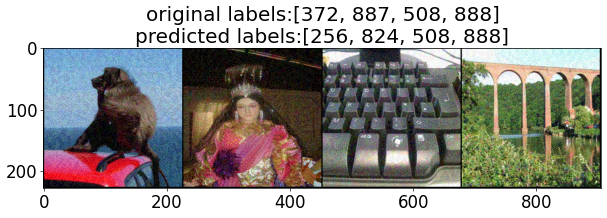

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: baboon (372)
Image #2: vestment (887)
Image #3: computer keyboard, keypad (508)
Image #4: viaduct (888)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Newfoundland, Newfoundland dog (256)
Image #2: stole (824)
Image #3: computer keyboard, keypad (508)
Image #4: viaduct (888)


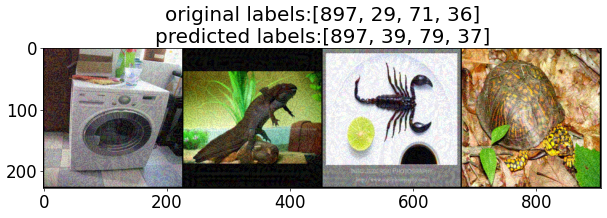

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: washer, automatic washer, washing machine (897)
Image #6: axolotl, mud puppy, Ambystoma mexicanum (29)
Image #7: scorpion (71)
Image #8: terrapin (36)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: washer, automatic washer, washing machine (897)
Image #6: common iguana, iguana, Iguana iguana (39)
Image #7: centipede (79)
Image #8: box turtle, box tortoise (37)
[Step #0] Loss: 0.3380 Accuracy: 31.2500% Time elapsed: 2.1164s (total 16 images)
[Step #10] Loss: 0.4555 Accuracy: 22.7273% Time elapsed: 6.3014s (total 176 images)
[Step #20] Loss: 0.4140 Accuracy: 25.8929% Time elapsed: 10.3255s (total 336 images)
[Step #30] Loss: 0.4223 Accuracy: 27.0161% Time elapsed: 14.4704s (total 496 images)
[Step #40] Loss: 0.4105 Accuracy: 26.8293% Time elapsed: 18.8506s (total 656 images)
[Step #50] Loss: 0.4142 Accuracy: 25.8578% Time elapsed: 23.1934s (total 816 images)
[Step #60] Loss: 0.4191 Accuracy: 25.4098% Time elapsed: 27.4193s (total 

In [24]:
# 블랙박스 공격 예제 코드입니다.
custom_attack = AI_FGM(eps=16/255, iters=4) # 공격용 파라미터 설정
black_box_attack_validate(resnet152, black_box_model, custom_attack)

In [25]:
torch.cuda.empty_cache()

In [26]:
class AI_FGM_ENSEMBLE:
    def __init__(self, eps, iters, decay1=0.999, decay2=0.999, delta=1e-8):
        self.eps = eps
        self.iters = iters
        self.decay1 = decay1
        self.decay2 = decay2
        self.delta = delta
    
    def perturb(self, models, weights, images, labels):
        images_org = images.clone()
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad = True
        size = images.shape[0]
        image_dim = torch.tensor(images.shape[1]*images.shape[2]*images.shape[3], dtype=torch.float32)

        m = 0
        v = 0
        alpha = self.eps * torch.sqrt(image_dim) * self.iters
        alpha_denom = 0
        attack_loss = nn.CrossEntropyLoss()

        for i in range(self.iters):
            outputs = 0

            for model, weight in zip(models, weights):
                output = model(images)
                
                model.zero_grad()
                outputs += weight*output

            images.retain_grad()
            cost = attack_loss(outputs, labels).to(device)
            cost.backward(retain_graph=True)
            
            images_grad_norm = images.grad.reshape(size, -1).norm(p=1, dim=1).reshape(size, 1, 1, 1)
            g = images.grad / images_grad_norm
            m = self.decay1*m + (1 - self.decay1)*g
            v = self.decay2*v + (1 - self.decay2)*torch.pow(g, 2.0)
            s = m / (self.delta + torch.sqrt(v))

            alpha_numer = torch.sqrt(torch.tensor(1 - self.decay2**(i+1))) / torch.tensor(1 - self.decay1**(i+1))
            alpha_denom += alpha_numer
            alpha = alpha*alpha_numer / alpha_denom

            images = images + alpha * s / s.reshape(size, -1).norm(p=2, dim=1).reshape(size, 1, 1, 1)
            images = torch.where(images > images_org + self.eps, images_org + self.eps, images)
            images = torch.where(images < images_org - self.eps, images_org - self.eps, images)
            images = torch.clamp(images, min=0, max=1)

        return images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


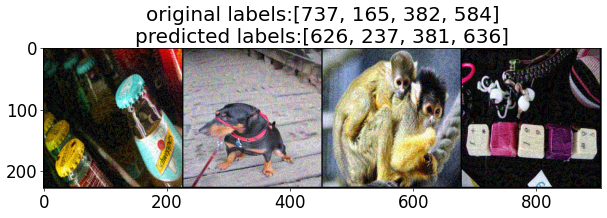

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: pop bottle, soda bottle (737)
Image #2: black-and-tan coonhound (165)
Image #3: squirrel monkey, Saimiri sciureus (382)
Image #4: hair slide (584)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: lighter, light, igniter, ignitor (626)
Image #2: miniature pinscher (237)
Image #3: spider monkey, Ateles geoffroyi (381)
Image #4: mailbag, postbag (636)


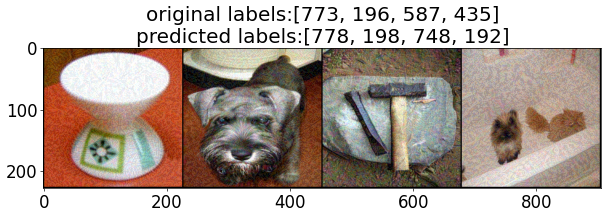

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: saltshaker, salt shaker (773)
Image #6: miniature schnauzer (196)
Image #7: hammer (587)
Image #8: bathtub, bathing tub, bath, tub (435)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: scale, weighing machine (778)
Image #6: standard schnauzer (198)
Image #7: purse (748)
Image #8: cairn, cairn terrier (192)
[Step #0] Loss: 0.7586 Accuracy: 6.2500% Time elapsed: 2.9458s (total 16 images)
[Step #10] Loss: 0.6670 Accuracy: 2.8409% Time elapsed: 14.8190s (total 176 images)
[Step #20] Loss: 0.6524 Accuracy: 6.2500% Time elapsed: 26.5945s (total 336 images)
[Step #30] Loss: 0.6489 Accuracy: 6.4516% Time elapsed: 38.3207s (total 496 images)
[Step #40] Loss: 0.6563 Accuracy: 6.7073% Time elapsed: 50.5610s (total 656 images)
[Step #50] Loss: 0.6562 Accuracy: 7.2304% Time elapsed: 61.7923s (total 816 images)
[Step #60] Loss: 0.6453 Accuracy: 8.1967% Time elapsed: 73.0317s (total 976 images)
[Step #70] Loss: 0.6410 Accuracy: 8.5387% Time el

In [27]:
models = [resnet152, vgg19, mobilenet_v2, densenet201, alexnet]
weights = [1/len(models)] * len(models)

custom_attack = AI_FGM_ENSEMBLE(eps=16/255, iters=4) # 공격용 파라미터 설정
black_box_attack_validate_ensemble(models, weights, black_box_model, custom_attack)

In [28]:
torch.cuda.empty_cache()

## MI-FGSM ([paper](https://arxiv.org/pdf/1710.06081.pdf))  
- Single model: 26.08%  
- Ensemble (5 models): 9.30%  
  
## AI-FGM ([paper](https://arxiv.org/ftp/arxiv/papers/2012/2012.00567.pdf))  
### 완벽히 구현되었는지는 모르겠음.
- Single model: 22.86%  
- Ensemble (5 models): 8.66%